<a name="cell-bijections-toc"></a>

### 12. [Transformation of Variables (Bijections)](#cell-bijections)

0. [Normalizing Flows](#cell-MCint-sampling-normalizingflows)
1. [Masked Autoregressive Flows (MAFs)](#cell-MCint-sampling-MAFs)
  0. [Masked Autoencoder Density Estimation (MADE)](#cell-MCint-sampling-MADE)
2. [Inverse Autoregressive Flows (IAFs)](#cell-MCint-sampling-IAFs)
3. [Real NVP: Easy Jacobian with Affine Transformations](#cell-MCint-sampling-RNVP)

In [ ]:
from IPython.display import YouTubeVideo

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers


<a name="cell-bijections"></a>

# 12 Transformation of Variables (or Bijections) ([Return to TOC](#cell-bijections-toc))

---

***Importance sampling*** and ***rejection sampling*** rely on sampling from a ***proposal distribution*** distribution and then using those samples in careful ways to produce samples from a different ***target distribution***.

Returning to this idea, for random variables $X$ and $Z$, the framework 

$${X}=g({Z}) \quad \text{with} \quad {Z}\sim \tilde p_{Z}({Z}={z}) \quad \Longrightarrow \quad {X}\sim p_{X}({X}={x})$$

provides a general strategy to produce samples from any arbitrary ***target distribution*** $x_i \sim p_{X}$ based on transforming samples from a ***proposal distribution*** $z_i \sim \tilde p_{Z}$ as $x_i=g(z_i)$ in order to  costruct the desired sample.

Implementation of this approach is based on the ***change of variables*** formula

$$\begin{align*}
p_{X}({x}) = {} & \tilde p_{Z}\big(\overbrace{g^{-1}({x})}^{{z}}\big) \left| \det J_{g^{-1}(\dot{{x}})}\!\left({x}\right) \right| = \tilde p_{Z}\big(g^{-1}({x})\big) \left| \; \det \left[ \begin{array}{ccc} \frac{\partial g^{-1}_1({x})}{\partial x_1} &\cdots &  \frac{\partial g^{-1}_1({x})}{\partial x_m} \\ \vdots & \ddots & \vdots \\ \frac{\partial g^{-1}_m({x})}{\partial x_1} &\cdots &  \frac{\partial g^{-1}_m({x})}{\partial x_m}\end{array} \right] \quad \right|\\
= {} & \tilde p_{Z}\big(\overbrace{g^{-1}({x})}^{{z}}\big) \left| \det J_{g(\dot{{z}})}\!\left({z}\right) \right|^{-1} = \tilde p_{Z}\big(z\big) \;\! \left| \; \det \left[ \begin{array}{ccc} \frac{\partial g_1({z})}{\partial z_1} &\cdots &  \frac{\partial g_1({z})}{\partial z_m} \\ \vdots & \ddots & \vdots \\ \frac{\partial g_m({z})}{\partial z_1} &\cdots &  \frac{\partial g_m({z})}{\partial z_m}\end{array} \right] \quad \right|^{-1}
\end{align*}$$

which shows that
1. $x$ and $z$ may be multivariate, and must have the same dimension $\dim({X})=\dim({Z})=m$
2. $g({z})$ must be ***monotonically increasing*** or ***decreasing***  
  - otherwise $g^{-1}({x})$ is not ***one to one*** so $g^{-1}({x}) = z \neq z' = g^{-1}({x})$ 
  - and $\tilde p\big(g^{-1}({x}) = z\big) \neq \tilde p\big(g^{-1}({x}) = z'\big)$ in general is ambiguous
3. the function $g({z})$, and hence $g^{-1}({x})$, must be differentiable 

  > where the dot in $\dot{{x}}$ is an abuse of Newton's [derivative notation](https://en.wikipedia.org/wiki/Notation_for_differentiation#Newton's_notation) used here to emphasize that the differentiation of the Jacobian will be with respect to the variables of ${x}$, and must then be evaluated at a specific value which is the argument of the function $J_{g^{-1}(\dot{{x}})}(\cdot)$.

A collection of objects satisfying this construction are called ***bijections*** in neural network parlance.

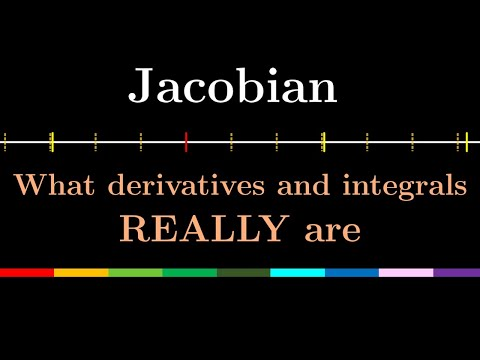

In [ ]:
YouTubeVideo('wCZ1VEmVjVo')

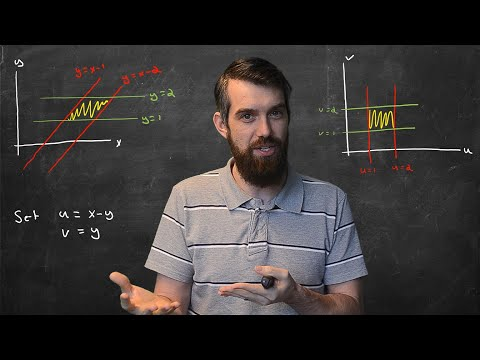

In [ ]:
YouTubeVideo('wUF-lyyWpUc')

<a name="cell-MCint-sampling-normalizingflows"></a>

## 12.0 Normalizing Flows ([Return to TOC](#cell-bijections-toc))

---

In neural network nomenclature a chained sequence of ***bijections***

- i.e., a sequence of ***change of variables*** transformations

$$\begin{align*}
X^{(k)} = g^{(k)}(X^{(k-1)}) \quad \text{ with } \quad X^{(k)} \sim {} & p_{X^{(k-1)}}\big({g^{(k)}}^{-1}\!\!\left(X^{(k)}\right)\big) \left| \det J_{{g^{(k)}}^{-1}(\dot{X^{(k)}})}\!\left(X^{(k)}\right) \right|\\
= {} & p_{X^{(k-1)}}\big(X^{(k-1)}\big) \, \left| \det J_{{g^{(k)}}(\dot{X^{(k-1)}})}\!\left(X^{(k-1)}\right) \right|^{-1} 
\end{align*}$$

where $p_{X^{(k-1)}}\big(X^{(k-1)}\big)$ is either known exactly or recursively defined as specified above so that

$$\begin{align*}
X^{(k)} \sim {} &  \tilde p_{X^{(0)}}\big({g^{(1)}}^{-1}\!\!\left(X^{(1)}\right)\big) \prod_{j=1}^k \left| \det J_{{g^{(j)}}^{-1}(\dot{X^{(j)}})}\!\left(X^{(j)}\right) \right|\\
= {} & \tilde p_{X^{(0)}}\big(X^{(0)}\big) \prod_{j=1}^k \left| \det J_{{g^{(j)}}(\dot{X^{(j-1)}})}\!\left(X^{(j-1)}\right) \right|^{-1}
\end{align*}$$

are termed ***flows***. And in particular, while $X^{(0)} \sim \tilde p_{X^{(0)}}(X^{(0)})$ may be specified as any distribution, if it is chosen to be $X^{(0)} \sim N(\mathbf{0},\mathbf{I})$ then the *flow* is termed a ***normalizing flow*** since the inverse transformations ***normalize*** 

$$X^{(0)} = {g^{(1)}}^{-1} \circ {g^{(2)}}^{-1} \circ \cdots \circ {g^{(k-1)}}^{-1} \circ {g^{(k)}}^{-1}( X^{(k)}) \quad \text{ so that } \quad X^{(0)} \sim N(\mathbf{0},\mathbf{I})$$

> ***Normalizing flows*** may be (equivalently) defined directly in terms of the transformations of an arbitrary distribution into a normal distribution as
>
> $$X^{(0)} = {f^{(1)}} \circ {f^{(2)}} \circ \cdots \circ {f^{(k-1)}} \circ {f^{(k)}}( X^{(k)}) \quad \text{ so that } \quad X^{(0)} \sim N(\mathbf{0},\mathbf{I})$$
>
> where ${f^{(j)}} = {g^{(j)}}^{-1}$ and the forward and inverse terminology are a matter of notational preference.

The reason ***flows*** exist is because 
1. the challenge of computing $\left| \det J_{g^{-1}(\dot{X})}\!\left(X\right)\right| = \left|\det J_{g(\dot{Z})}\!\left(Z\right)\right|^{-1}$ generally precludes the use of a single sufficiently complex transformation $g$ which might be able to transform an arbitrary random variable $X^{(0)}\sim \tilde p_X^{(0)}$ to some other arbitrary random variable $X \sim p_X$
2. but a chained sequence of simpler transformations $g^{(k)}$ for which $\left | \det J_{{g^{(k)}}^{-1}(\dot{X^{(k)}})}\!\left(X^{(k)}\right) \right| = \left | \det J_{{g^{(k)}}(\dot{X^{(k-1)}})}\!\left(X^{(k-1)}\right) \right|^{-1}$ are not hard to compute could create a process that is able to transform an arbitrary distribution $X^{(0)} \sim \tilde p_X^{(0)}$ into some other arbitrary distribution $X \sim p_X$.

> An initial proposal for a sequence of simple transformation functions $g^{(k)}$ that might be adequate to perform the necessary arbitrary transformations is to use nonlinear elementwise transformations $\phi$
>
> - generally called ***activation functions*** 
> 
> of ***affine ($Ax+b$) transformations*** 
>
> $$ g^{(k)}\! \left(X^{(k)}\right) = \phi \odot (A_k X^{(k)} + b_k)$$
> 
> The motivation for this proposal is that such a sequence defines a ***neural network*** which is a ***universal estimator*** that can theoretically model any function (i.e., transformation).
>
> Unfortunately, while ${g^{(k)}}^{-1}(X^{(k)})$ exists for many choices for $\phi$ where $\phi$ will not greatly complicate Jacobian calculations, without the activation function 
> 
> $$\det J_{A_k X^{(k)} + b_k}=|\det A_k|^{-1}$$
>
> is not a simple calculation for arbitrary $A_k$. Therefore, further refinement of this naive approach will be required to create computationally tractable.

<a name="cell-MCint-sampling-MAFs"></a>

## 12.1 Masked Autoregressive Flows (MAFs) ([Return to TOC](#cell-bijections-toc))

---

A ***masked autoregressive flow*** (***MAF***) is one way to make the Jacobian calculation tractable when using ***neural network*** (***NN***) style (i.e., elementwise nonlinear ***activation functions*** of ***affine transformations***) specifications.

Using a ***full conditional autoregressive dependency*** structure across the dimensions of the random variable $X$

$$\begin{align*}
X^{(t)}_0 = {} &  \mu^{(t)}_{0} +  \sigma^{(t)}_{0} \cdot X^{(t-1)}_0\\
X^{(t)}_j = {} & \underset{\text{nonlinear functions, e.g., NNs}}{\underbrace{ \mu^{(t)}_{j}(X^{(t)}_{0:j-1}) +  \sigma^{(t)}_{j}(X^{(t)}_{0:j-1})}_{\text{$ \mu^{(t)}$ and $ \sigma^{(t)}$ are autoregressive}}} \cdot  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

the transformation and inverse may be expressed as 

$$\begin{align*}
X^{(t)} = g^{(t)}(X^{(t-1)}) = {} & \boldsymbol \mu^{(t)}_{X^{(t)}} + \text{diag}(\boldsymbol \sigma^{(t)}_{X^{(t)}}) X^{(t-1)} \\
X^{(t-1)} = {g^{(t)}}^{-1}(X^{(t)}) = {} & \frac{X^{(t)} - \boldsymbol \mu_{X^{(t)}}^{(t)}}{ {\text{diag}{(\boldsymbol \sigma_{X^{(t)}}^{(t)}}})}
\end{align*}$$

with 

$$\begin{align*}
{} & \left| \det J_{{g^{(t)}}^{-1}(\dot X^{(t)})}(X^{(t)}) \right| = \left| \det J_{{g^{(t)}}(\dot X^{(t-1)})}(X^{(t-1)}) \right|^{-1} = 
 \left | \; \det \left[ \begin{array}{ccc}
\frac{\partial X^{(t)}_0}{\partial X^{(t-1)}_0} &
\cdots & \frac{\partial X^{(t)}_0}{\partial X^{(t-1)}_m} \\
\vdots & \ddots & \vdots \\
\frac{\partial X^{(t)}_m}{\partial X^{(t-1)}_0} &
\cdots & \frac{\partial X^{(t)}_m}{\partial X^{(t-1)}_m} 
 \end{array} \right] \; \right |^{-1} \\
= {} & \left | \; \det \left[ \begin{array}{ccc}
\sigma_0^{(t)} &  & 0 \\
 & \ddots \quad\quad\quad \;\;& \\
 &  \sigma_j^{(t)}(X_{0:(j-1)}^{(t)}) &\\
 &  \quad\quad\quad\quad \ddots & \\
0 & & \sigma_m^{(t)}(X_{0:(m-1)}^{(t)}) 
 \end{array} \right] \;\right |^{-1} = 
 \left |\det \text{diag}(\boldsymbol \sigma^{(t)}_{X^{(t)}}) \right|^{-1} =  \left |\prod_{j=1}^m  \text{diag}(\boldsymbol \sigma^{(t)}_{X^{(t)}})_{jj} \right|^{-1}
\end{align*}$$

so that

$$\log p_{X^{(k)}}(x^{(k)}) = \log p_{X^{(0)}}(x^{(0)}) - \sum_{t=1}^k \log \left |\prod_{j=1}^m  \text{diag}(\boldsymbol \sigma^{(t)}_{x^{(t)}})_{jj} \right| $$

which 

- follows from

$$\begin{align*}
X^{(k)} \sim {} &  \tilde p_{X^{(0)}}\big({g^{(1)}}^{-1}\!\!\left(X^{(1)}\right)\big) \prod_{j=1}^k \left| \det J_{{g^{(j)}}^{-1}(\dot{X^{(j)}})}\!\left(X^{(j)}\right) \right|\\
= {} & \tilde p_{X^{(0)}}\big(X^{(0)}\big) \prod_{j=1}^k \left| \det J_{{g^{(j)}}(\dot{X^{(j-1)}})}\!\left(X^{(j-1)}\right) \right|^{-1}
\end{align*}$$

- and since this does not require a general Jacobian calculation it is readily computable.

This specification is called a ***masked autoregressive flow*** (***MAF***) where

- ***masked autoregressive*** refers to enforcing the way inputs are utilized 
  - with $\boldsymbol \mu^{(t)}_{X^{(t)}}$ and $\boldsymbol \sigma^{(t)}_{X^{(t)}}$ specified as ***neural networks*** with outputs $\boldsymbol \mu^{(t)}_j(X_{0:(j-1)}^{(t)})$ that are only dependent on inputs $j' < j$ by cutting, i.e. "masking" neural network connections 
- and ***flow*** refers to the use a seqeunce of ***masked autoregressive bijections***.

<a name="cell-MCint-sampling-MADE"></a>

### 12.1.0 Masked Autoencoder Density Estimation (MADE) ([Return to TOC](#cell-bijections-toc))

---

While Jacobian determinants are easy calculations for a ***MAF*** specification, a single ***autoregressive*** tranformation (as opposed to a ***flow***) can also produce a probability distribution, but without the need to make any "determinant of the Jacobian" correction factor adjustments. 

By parameterizing conditional distributions with an ***autoregressive*** dependence structure

$$p_{X_k|X_{k-1}, \cdots, X_1}(x_k|x_1,\cdots,x_{k-1}) = p_{\theta_k(x_1,\cdots,x_{k-1})}(x_k)$$ 

based on some parametric probability distribution family $p_{\theta_k}$, the a joint distribution can be reconstructed from the ***chain rule***

$$\begin{align*}
p(x_1, \cdots, x_k) = {} & \prod_{j=1}^k p_{X_j|X_{j-1},\cdots,X_1}(x_j|x_{j-1},\cdots,x_1)\\
= {} & \prod_{j=1}^k p_{\theta_j(x_1,\cdots,x_{j-1})}(x_j)
\end{align*}$$

In ***Masked Autoencoder Distribution Estmation*** (***MADE***) methodology, the function $\theta_k(x_1,\cdots,x_{k-1})$ parameterizing the parametric probability distribution $p_{\theta_k}$ is a neural network and

- ***masked*** again refers to the ***autoregressive*** usage of $X_1, \cdots, X_{j-1}$ relative to $X_j$
  - which is exactly the same conditional dependence structure (repeatedly) applied in the ***MAF*** specification, but in ***MADE*** this conditional dependency mechanism is specified in terms of explicit conditional probability densities
  
- and ***autoencoder*** refers to the fact that $X_1, \cdots, X_k$ is both the input which defines $p_{\theta(x_1,\cdots,x_{k})}(x_1, \cdots, x_k)$ as well as the output on which it is evaluated
  - although of course the structure of the input driving the output is still ***autoregressively conditional***.

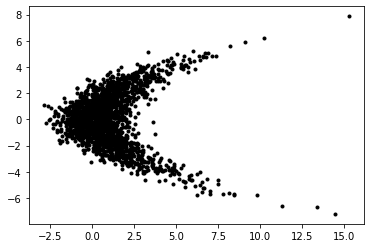

In [ ]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork
n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
# note (1) that it's most informative to condition as p(x2)p(x1|x2)
# note (2) that x1 is more than a shift-scale transformation of x1

data = np.stack([x1,x2], axis=-1)
plt.plot(x1,x2,'k.')

(None, 2)


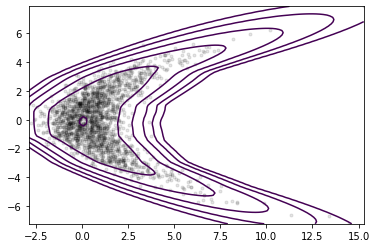

In [ ]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork
ARN = tfb.AutoregressiveNetwork(params=2, hidden_units=[25, 25], 
                                activation='relu', input_order='right-to-left')
# Input: (not yet specified); but, it will be 
#        [batch, dimension_of_an_observation] = [n,q]
# Output: count of real-valued autoregressive outputs for each dimension_of_an_observation
#        [n,params,q] = [n,2,q] which can be used as mu_j and log(sigma_j)
#        defining autoregressive conditional distributions p(x_j|x_j-1,...,x_0) = N(mu_j,exp(log_sigma_j)) 
#        i.e., jth entry in params axis depends on inputs j-1,...,0
# Network: (will enforce the Autoregressive property with Masking)
# `hidden_units=[latent_variables, latent_outputs] = [10, 10]` 
# [n, q] x [q, latent_variables] x [latent_variables, transformed_variables] x 
# [transformed_variables, params, q] = [n, params, q]
#  
# note (1) that `input_order='right-to-left'` gets the natural conditioning direction correct
# note (2) that `activation='relu'` allows the neural network to use nonlinear transformations
# e.g., a "v" shape can be made by relu(x2) for x2>0 and relu(-x2) for x2<0; and,
# the "piecewise" feel below is from using differently offset and scaled relu functions 

x_ = tfkl.Input(shape=(2,), dtype=tf.float32) # [n,q]
# In tensorflow `shape=(2,)` specifies the dimension of a single observation (q)
# while `batch` is assumed as the first dimension (`None` will be `n`)
print(x_.shape)
# https://www.tensorflow.org/probability/api_docs/python/tfp/layers/IndependentNormal
MADE = tfk.Sequential([x_, ARN, tfkl.Flatten(data_format='channels_first'), 
                       tfpl.IndependentNormal(2)])
# `tfpl.IndependentNormal(2)` inputs are mu_1, mu_2, log_sigma_1, log_sigma_2 
# but `ARN` output is [[mu_1,log_sigma_1],[mu_2,log_sigma_2]] so
# `data_format='channels_first'` reads the mu's first and then the log_sigma's
# i.e., [i,k,j] iterates in i,j,k order over [n, params, q] and j=0 is mu's

# https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html
negloglik = lambda x, p_x: -p_x.log_prob(x)
MADE.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
MADE.fit(data, data, epochs=20, verbose=False)

g = 100
g1,g2 = np.meshgrid(np.linspace(x1.min(), x1.max(), g), 
                  np.linspace(x2.min(), x2.max(), g))
grid = np.stack([g1.flatten(), g2.flatten()], axis=-1)
plt.plot(x1, x2, 'k.', alpha=0.1)
plt.contour(g1, g2, np.exp(MADE(grid).log_prob(grid).numpy().reshape(g,g)),
            levels=np.logspace(-5,2,10))

(None, 2)


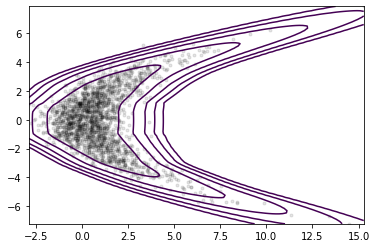

In [ ]:
# Rather than parameterizing conditional distributions with 
ARN = tfb.AutoregressiveNetwork(params=2, hidden_units=[512, 512], 
                                activation='relu', input_order='right-to-left')
# this can (equivalently) define a shift-scale transformation 
# of Z_j\sim N(0,1), i.e., Z_j*exp(log_sigma_j))+mu_j for an MAF
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow
# https://arxiv.org/abs/1502.03509 # 2015 MADE: masked autoencoder for distribution estimation
# https://arxiv.org/abs/1705.07057 # 2017 masked autoregressive flow for density estimation

# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/TransformedDistribution
p_X = tfd.TransformedDistribution(
    # `tfd.TransformedDistribution` models x the observed data
    # by p(x) = bijector(p(z)) where `bijector` is learned to transform p(z)
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]), 
    # `distribution` is p(z); but, this need not be a normal distribution
    bijector=tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=ARN))
    # `tfb.MaskedAutoregressiveFlow` defines forward, inverse, and jacobian 
    # of an MAF (i.e., univariate transforms of autoregressive conditionals) 
    # for any `bijector_fn`; but, here we specify that to be a shift-scale
    # transformation with the convenience `shift_and_log_scale_fn` argument   
    # which accepts ARN outputs as inputs to define the shift-scale transform
    
x_ = tfkl.Input(shape=(2,), dtype=tf.float32) # data
print(x_.shape)
log_prob_ = p_X.log_prob(x_) # log p(x) determined by 
# 1. MAF transforming the data to the base distribution p(z)
# 2. computing p(MAF(z)) and all necessary jacobian product corrections
# However, the MAF transform is the shift-scale ARN, which will be an 
# autoregressive neural netwok with input x 
# how to use x autoregressively to transform x into z
MAF = tfk.Model(x_, log_prob_)
# input: x_ is the data
# output: log_prob_ is a function of input x_ so when x_ enters `tfk.Model`
#         it is passed to log_prob_ which calculates based on ARN which has free
#         neural network parameters that may be changed to make improve log_prob_

MAF.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
            loss=lambda x, log_prob: -log_prob) # our target log(p(x)=1) is 0
MAF.fit(x=data, y=np.zeros((n, 0), dtype=np.float32),
        batch_size=256, epochs=50, steps_per_epoch=8,  # Usually `n // batch_size`.
        shuffle=True, verbose=False)

plt.plot(x1, x2, 'k.', alpha=0.1)
plt.contour(g1, g2, p_X.prob(grid).numpy().reshape(g,g), 
            levels=np.logspace(-5,2,10))

> The `Bijectors` class in TensorFlow implements required forward and inverse transformations and determinants of the Jacobian of these transformations; thus, ***normalizing flows*** can be employed in TensorFlow by chaining together `Bijectors` and all the necessary transformations and Jacobian adjustments will be taken care of by the TensorFlow `Bijectors`.
>
> TensorFlow supports ***normalizing flows*** because neural networks can theoretically produce an arbitrary transformations representing any function (i.e., any transformation), so the neural networks can learn the necessary change of variables transformation needed to represent arbitrary data distributions.

<a name="cell-MCint-sampling-IAFs"></a>

## 12.2 Inverse Autoregressive Flows (IAFs) ([Return to TOC](#cell-bijections-toc))

---

A consideration of the ***MAF*** specification is that sampling from each transformed random variable $X^{(t)}$ as

$$\begin{align*}
X^{(t)}_0 = {} &  \mu^t_{0} +  \sigma^t_{0} \cdot X^{(t-1)}_0\\
X^{(t)}_j = {} & \mu^{(t)}_{j}(X^{(t)}_{0:j-1}) +  \sigma^{(t)}_{j}(X^{(t)}_{0:j-1}) \cdot  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

must be done sequentially because $\mu^{(t)}_{j}$ depends on the previously sampled $X^{(t)}_{0:j-1}$.

The ***Inverse Autoregressive Flow*** (***IAF***) specification seeks to address this by instead using the transformation  

$$\begin{align*}
X^{(t)}_0 = {} &  \mu^t_{0} +  \sigma^t_{0} \cdot X^{(t-1)}_0\\
X^{(t)}_j = {} & \mu^{(t)}_{j}(X^{(t-1)}_{0:j-1}) +  \sigma^{(t)}_{j}(X^{(t-1)}_{0:j-1}) \cdot  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

This difference is that this allows each $X^{(t)}_j$ to be computed in parallel once $X^{(t-1)}$ is available.  So while the ***flow*** is still sequential, each multivariate $X^{(t)}$ can be computer much faster (in parallel) for ***IAF*** compared to ***MAF***.

The ***IAF*** is not universally preferred over ***MAF***, however, since the   discussion above applies to sampling. If interest is instead in evaluating 
$p_{X^{(t)}}(x^{(t)})$, then it is the sequence of inverse transformations that are required in order to transform $x^{(t)}$ into $x^{(0)}$. In this case, the inverse transformations are 

- ***IAF***

$$\begin{align*}
\frac{X^{(t)}_j - \mu^{(t)}_{j}(X^{(t-1)}_{0:j-1})}{\sigma^{(t)}_{j}(X^{(t-1)}_{0:j-1}) } = {} &  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

- ***MAF***

$$\begin{align*}
\frac{X^{(t)}_j - \mu^{(t)}_{j}(X^{(t)}_{0:j-1})}{ \sigma^{(t)}_{j}(X^{(t)}_{0:j-1})} = {} &   X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

which means that now it's the ***MAF*** context that allows each $X^{(t-1)}_j$ to be computed in parallel once $X^{(t)}$ becomes available. 

Thus, for the purposes of computing 

$$\log p_{X^{(k)}}(x^{(k)}) = \log p_{X^{(0)}}(x^{(0)}) - \sum_{t=1}^k \log \left |\prod_{j=1}^m  \text{diag}(\boldsymbol \sigma^{(t)}_{x^{(t)}})_{jj} \right| $$

the necessary ***MAF*** transformations can be computed (in parallel) much faster than the necessary ***IAF*** transformations. 


To summarize, the ***flow*** in ***MAF*** and ***IAF*** is sequential, but each individual ***bijection*** in the ***flow*** which creates a multivariate transformation is not necessarily sequential and can be parallelized as follows

- the ***IAF*** forward transformaion $X^{(k)} = g^{(k)}(X^{(k-1)}) = g_{X^{(k-1)}}(X^{(k-1)})$ (needed for sampling) can be parallelized and thus sampling can be done more quickly when using the ***IAF*** specification compared to the ***MAF*** specification

- the ***MAF*** inverse transformation $X^{(k-1)}={g^{(k)}}^{-1}(X^{(k)}) = g_{X^{(k)}}^{-1}(X^{(k)})$ (needed for probability calculations) can be parallelized and thus densities can evaluted more quickly when using the ***MAF*** specification compared to the ***IAF*** specification

In [ ]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow#examples_3
dims = 100
# defined just like above; except, with different dims
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[25, 25])))

In [ ]:
%%time 
x = maf.sample() # Expensive; uses `tf.while_loop`, no Bijector caching.

CPU times: user 1.12 s, sys: 5.05 ms, total: 1.12 s
Wall time: 1.26 s


In [ ]:
%%time 
_ = maf.log_prob(x) # Almost free; uses Bijector caching.

CPU times: user 32.1 ms, sys: 0 ns, total: 32.1 ms
Wall time: 57.9 ms


In [ ]:
%%time
_ = maf.log_prob(tf.zeros(dims)) # Cheap; no `tf.while_loop` despite no Bijector caching.

CPU times: user 31.4 ms, sys: 0 ns, total: 31.4 ms
Wall time: 36.5 ms


In [ ]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow#examples_3
iaf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
            #only this inversion has changed relative to the `maf` object above
            #IAF is indeed appropriately named, as it can be defined by inverting the MAF specification
    bijector=tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[25, 25]))))

In [ ]:
%%time
x = iaf.sample()  # Cheap; no `tf.while_loop` despite no Bijector caching.

CPU times: user 98.1 ms, sys: 568 µs, total: 98.6 ms
Wall time: 124 ms


In [ ]:
%%time
_ = iaf.log_prob(x)   # Almost free; uses Bijector caching.

CPU times: user 29.5 ms, sys: 944 µs, total: 30.5 ms
Wall time: 66.1 ms


In [ ]:
%%time
_ = iaf.log_prob(tf.zeros(dims)) # Expensive; uses `tf.while_loop`, no Bijector caching.

CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 2.03 s


<a name="cell-MCint-sampling-RNVP"></a>

## 12.3 Real NVP: Easy Jacobian with Affine Transformations ([Return to TOC](#cell-bijections-toc))

---

For a sequence of ***bijections*** $g^{(k)}$ transforming 

$$X^{(k-1)} = {g^{(k)}}^{-1}(X^{(k)})$$

the so-called ***Real (valued) NVP (non volume preserving)*** specification is a ***normalizing flow*** where

$${g^{(k)}}^{-1}(X^{(k)}) = \left\{\begin{array}{rcl}
 X^{(k-1)}_{1:n/2} & = & {g_{A}^{(k)}}^{-1}(X^{(k)}) =  X^{(k)}_{1:n/2} \\
 X^{(k-1)}_{(n+1):n} & = & {g_{B}^{(k)}}^{-1}(X^{(k)}) = \overbrace{X^{(k)}_{(n+1):n}\circ \boldsymbol{\sigma}(X^{(k)}_{1:n/2})}^{\text{element-wise scaling}} + \boldsymbol{\mu}(X^{(k)}_{1:n/2})
\end{array}  \right.$$

only transforms half of the elements of the $X^{(k)}$ vector 

> and for each step $k$ the order of the elements in the $X^{(k)}$ vector will be randomly permuted so it's not always same elements being transformed.

The key difference of this approach compared to the ***MAF*** and ***IAF*** is that the dependency structure within $X^{(k)}$ is no longer ***autoregressive***. This makes the ***Real NVP*** more attractive computationally. It also means that the ***Real NVP*** can potentially be more expressive than ***MAF*** and ***IAF*** specifications because $\boldsymbol{\mu}(X^{(k)}_{1:n/2})$ and $\boldsymbol{\sigma}(X^{(k)}_{1:n/2})$ can now be arbitrary NNs (without an ***autoregressive*** restriction). 

The reason does not produce a computationally intractable Jacobian computation is because the Jacobian is a traiangular matrix


$$J_{{g^{(k)}}^{-1}(\dot X^{(k)})}(x^{(k)}) = 
\left[\begin{array}{cc} 
I & 0\\
J_{{g_{B}^{(k)}}^{-1}(\dot{X^{(k)}_{1:n/2}},X^{(k)}_{(n+1):n})}(x^{(k)}) & \text{diag}\left(\boldsymbol{\sigma}(X^{(k)}_{1:n/2})\right)
\end{array} \right]$$

and for any triangular matrix $\det L = \prod_{j=1}^{n} \text{diag}(L)_{jj}$

$$\left| \det J_{{g^{(k)}}^{-1}(\dot X^{(k)})}(x^{(k)}) \right| = \left| \prod_{j=1}^{n/2} \boldsymbol{\sigma}_j(X^{(k)}_{1:n/2}) \right|$$

So, the ***Real NVP*** specifiation provides the same diagonal multiplication computational tractability for the Jocabian calcuation as the ***MAF*** and ***IAF***, while not needing to maintain their ***autoregressive*** 
requirement. 